# The data

The simulated data has a sampling rate of 4096 Hz, meaning that measurements were taken 4096 times per second. This high sampling rate enables precise capturing of the waveforms' characteristics and ensures accurate analysis.

Furthermore, the data is divided into windows of 2 seconds each. This window size provides a suitable duration for analyzing the waveforms and extracting meaningful features.

### Let's download our data set which we will use for our goal

In [ ]:
import os
try:
    import wget

except:
    ! pip install -q "wget"

try:
    import requests
except:
    ! pip install -q "requests"

import tqdm
def download(url: str, filename: str):
    with open(filename, 'wb') as f:
        with requests.get(url, stream=True) as r:
            r.raise_for_status()
            total = int(r.headers.get('content-length', 0))

            # tqdm has many interesting parameters. Feel free to experiment!
            tqdm_params = {
                'desc': url,
                'total': total,
                'miniters': 1,
                'unit': 'B',
                'unit_scale': True,
                'unit_divisor': 1024,
            }
            with tqdm.tqdm(**tqdm_params) as pb:
                for chunk in r.iter_content(chunk_size=8192):
                    pb.update(len(chunk))
                    f.write(chunk)

In [ ]:
url_orig = "https://owncloud.ego-gw.it/index.php/s/Ff4i0ccG1HIg0mc/download"
target_data_path = '../../data/'

if not os.path.exists(target_data_path):
    os.mkdir(target_data_path)

target_file= '../../data/datasets.tgz'

if not os.path.isfile(target_file):
    download(url_orig, target_file)

In [ ]:
import tarfile
target_path = '../../data/timeseries/'

if not os.path.exists(target_path):
    os.mkdir(target_path)

tardata = tarfile.open(target_file)
tardata.extractall(target_path) # specify which folder to extract to
tardata.close()

You have access to 4 different types of signals: 3 from core-collapse supernovae (CCSN) and 1 from chirp waveforms. Specifically, for CCSN, we have: Non Exploding, Neutrino Explosion Mechanism, and Magnetorotational Explosion Mechanism.

- Non Exploding: This type of CCSN signal represents cases where the core-collapse supernova event does not result in a successful explosion. The collapse of the stellar core occurs without a significant release of energy, leading to a lack of observable explosion-related gravitational waveforms.

- Neutrino Explosion Mechanism: The Neutrino Explosion Mechanism signals correspond to core-collapse supernovae that undergo a successful explosion primarily driven by neutrino interactions. In this scenario, the intense neutrino flux plays a crucial role in reviving the shock wave, leading to the release of gravitational wave energy.

- Magnetorotational Explosion Mechanism: The Magnetorotational Explosion Mechanism signals are associated with core-collapse supernovae in which the magnetic fields and rotation of the collapsing star contribute to the explosion mechanism. These signals exhibit distinct characteristics resulting from the interplay between magnetic fields, rotation, and the dynamics of the explosion.

- In addition to the CCSN signals, there is also a chirplet waveform available for analysis. These signals exhibit a characteristic "chirping" behavior, where the frequency and amplitude change over time.

By studying and classifying these diverse signal types, we aim to deepen our understanding of the physical processes behind core-collapse supernovae and binary mergers, enhance our ability to detect and interpret gravitational wave data, and gain insights into the astrophysical phenomena driving these events.


1. NON EXPLODING (modello z100) J. Powell, B. Müller, and A. Heger, Mon. Not. Roy. Astron. Soc. 503, 2108 (2021), 2101.06889.
2. NEUTRINO(s18):Monthly Notices of the Royal Astronomical Society, Volume 487, Issue 1, July 2019, Pages (edited)
3. MAGNETOROTATIONAL (m39): Monthly Notices of the Royal Astronomical Society, Volume 522, Issue 4, July 2023, Pages 6070–6086, https://doi.org/10.1093/mnras/stad1292

In [ ]:
try:
    import sklearn
except:
    ! pip install -q "scikit-learn"

In [ ]:
try:
    import tensorflow as tf
except:
    ! pip install -q "tensorflow"

## 2D Convolutional Neural Networks (CNNs)

2D Convolutional Neural Networks (CNNs) are specifically designed for processing structured grid-like data, such as images. They excel at capturing spatial dependencies and extracting relevant features, making them widely used in computer vision tasks like object detection, image classification, and image segmentation.

### Fundamental Components

The fundamental components of a 2D CNN are as follows:

#### Convolutional Layers

Convolutional layers apply filters, or kernels, to input images to extract local patterns or features. By sliding the filters across the image, element-wise multiplications and summations are performed to produce feature maps. The depth of the feature maps corresponds to the number of applied filters. Convolutional layers allow the network to learn hierarchical representations by detecting low-level features (e.g., edges) in earlier layers and high-level features (e.g., shapes and textures) in deeper layers.

#### Pooling Layers

Pooling layers downsample the feature maps obtained from convolutional layers, reducing the spatial dimensions of the data. Commonly, max pooling is used, where the maximum value within a pooling window becomes the representative value for that region. Pooling helps reduce computational complexity and control overfitting by extracting the most salient features while preserving spatial invariance.

#### Fully Connected Layers

Fully connected layers, also known as dense layers, are added at the end of the network to perform classification or regression tasks. The feature maps from preceding layers are flattened into a vector and passed through one or more dense layers. These layers learn to associate the extracted features with specific classes. The final output layer usually employs an activation function (e.g., softmax for classification) to produce the desired output.

### Additional Architectural Elements

In addition to the core components, CNNs may include other architectural elements such as:

- Dropout regularization
- Batch normalization
- Activation functions (e.g., ReLU)

These additions aim to enhance model performance, expedite training, and prevent overfitting.

### Training Process

During training, CNNs optimize their internal parameters (weights and biases) through backpropagation and gradient descent. This process involves minimizing a defined loss function. The model is trained on a labeled dataset, and the weights are iteratively adjusted to minimize the discrepancy between predicted and actual labels.

### Conclusion

Overall, 2D CNNs have revolutionized computer vision by automatically extracting intricate features from images. Their remarkable performance in various image-related tasks has made them an indispensable tool in the field.


### Let's have a look at the signal in time-domain and time-frequency map
This data have been already whitened, so most of colored noise have been removed. We can have a look in the time-domain and in the Time-frequency one.

In [ ]:
import matplotlib.pyplot as plt
import IPython
import IPython.display
import matplotlib as mpl
from matplotlib import cm
from scipy import signal
from matplotlib.colors import LogNorm
from PIL import Image

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False
import numpy as np
def prepareImage_cwt(x, y, fs, title="title"):
    """
    Create and display a Continuous Wavelet Transform (CWT) spectrogram plot.

    Parameters:
        x (numpy.ndarray): Time values.
        y (numpy.ndarray): Signal data.
        fs (float): Sampling frequency.
        title (str, optional): Title for the plot (default is "title").

    Returns:
        None
    """
    w = 6.
    freq = np.linspace(1, fs/2, int(fs/2))
    widths = w * fs / (2 * freq * np.pi)
    z = np.abs(signal.cwt(y, signal.morlet2, widths, w=w))**2

    plt.pcolormesh(x, freq, z, cmap='PuBu', shading='gouraud', alpha=0.95, norm=LogNorm())
    plt.yscale('log')
    plt.ylim(1, fs/2)
    plt.title(str(title))
    plt.show()
def prepareImage_ml(y, fs, title):
    """
    Create and display a spectrogram plot using the Short-Time Fourier Transform (STFT).

    Parameters:
        y (numpy.ndarray): Signal data.
        fs (float): Sampling frequency.
        title (str): Title for the plot.

    Returns:
        None
    """
    f, t, Sxx = signal.spectrogram(y, fs)
    plt.pcolormesh(t, f, Sxx, cmap='PuBu', shading='gouraud', alpha=0.95, norm=LogNorm())
    #plt.yscale('log')
    plt.ylim(1, fs/2)
    #plt.axis('off')
    plt.title(str(title))
    plt.xlabel('Time (secs)')
    plt.ylabel('Frequency (Hz)')
    plt.colorbar()
    plt.show()




In [ ]:
chirp= np.load(target_path+'chirp/'+'chirp_snr30_1.npy')
magrot=np.load(target_path+'magrot/'+'magrot_snr30_1.npy')
neutrino=np.load(target_path+'neutrino/'+'neutrino_snr30_1.npy')
noexp=np.load(target_path+'noexp/'+'noexp_snr30_1.npy')


In [ ]:
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

# Define a custom colormap with blue, purple, and pink shades
colors = [(0.0, 0.0, 1.0), (0.5, 0.0, 0.5), (1.0, 0.0, 1.0)]  # Blue, purple, pink
n_bins = 100  # Discretize the colormap into 100 bins
cmap_name = 'custom_colormap'
custom_cmap = LinearSegmentedColormap.from_list(cmap_name, colors, N=n_bins)

# Apply custom colormap to all plots
mpl.rcParams['image.cmap'] = 'magma'


Text(0.5, 1.0, 'No explosion mechanism')

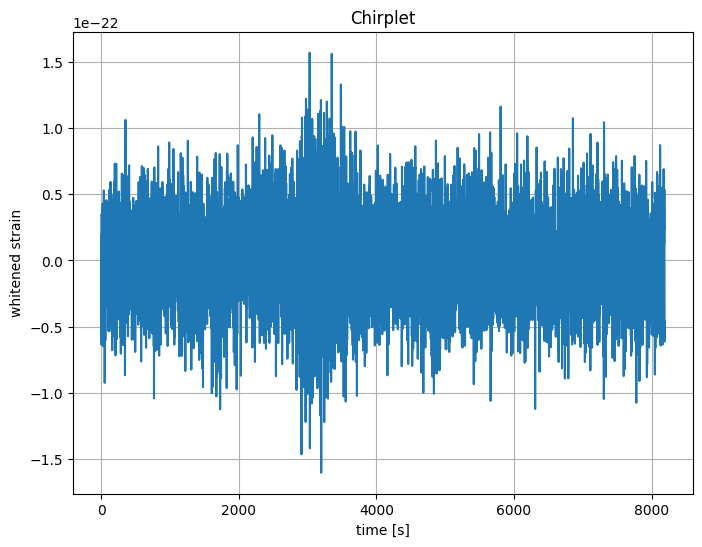

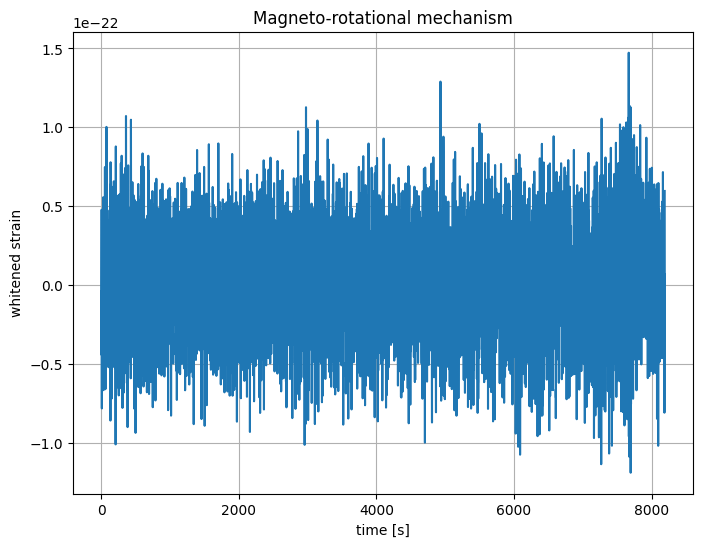

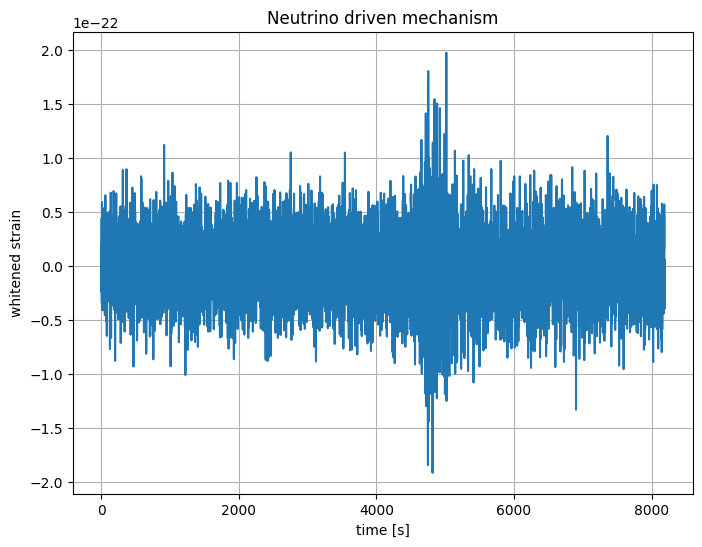

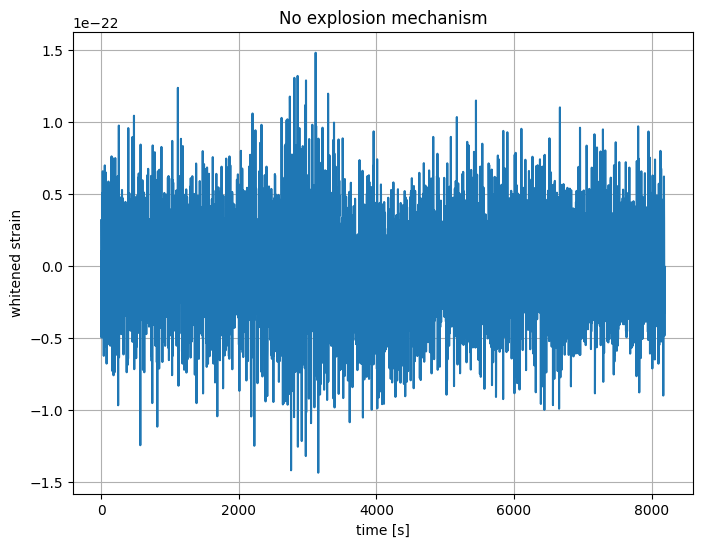

In [ ]:
#%matplotlib widget
plt.figure()
plt.grid(), plt.xlabel('time [s]'), plt.ylabel('whitened strain')
plt.plot(chirp,label='Chirplet')
plt.title('Chirplet')
plt.figure()
plt.grid(), plt.xlabel('time [s]'), plt.ylabel('whitened strain')
plt.plot(magrot,label='Magneto-rotational mechanism')
plt.title('Magneto-rotational mechanism')
plt.figure()
plt.grid(), plt.xlabel('time [s]'), plt.ylabel('whitened strain')
plt.plot(neutrino,label='Neutrino driven mechanism')
plt.title('Neutrino driven mechanism')
plt.figure()
plt.grid(), plt.xlabel('time [s]'), plt.ylabel('whitened strain')
plt.plot(noexp,label='No explosion mechanism')
plt.title('No explosion mechanism')

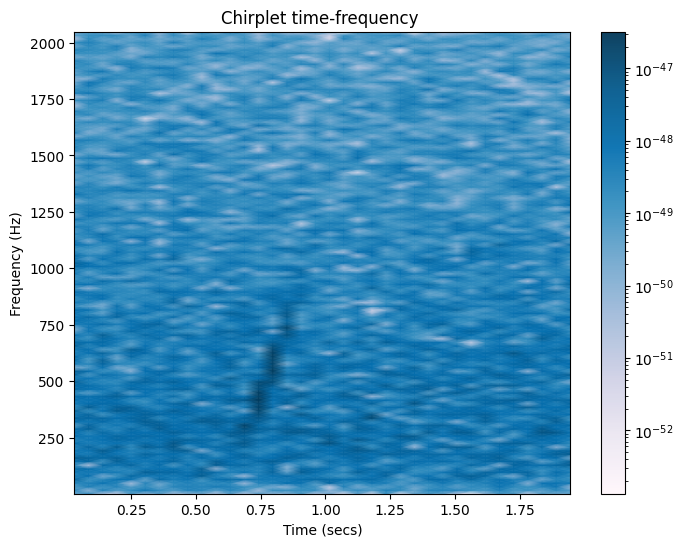

In [ ]:
fs=4096
dt=1/fs
x=np.arange(0,2, dt, dtype=None)
prepareImage_ml(chirp,fs,"Chirplet time-frequency ")

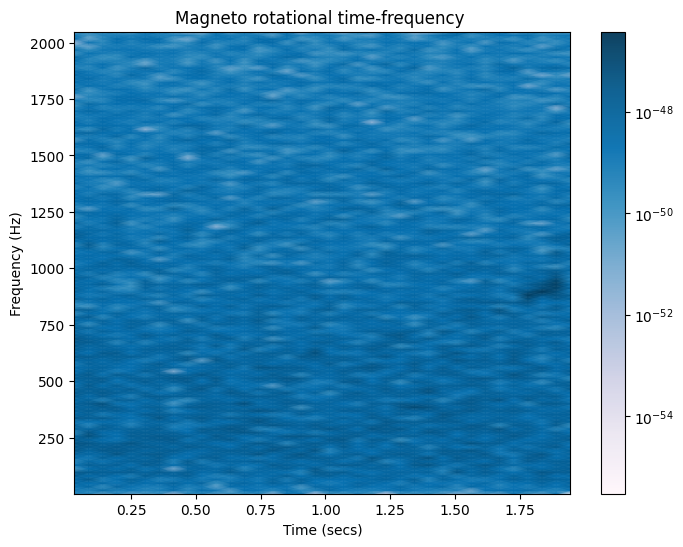

In [ ]:
prepareImage_ml(magrot,fs,"Magneto rotational time-frequency ")

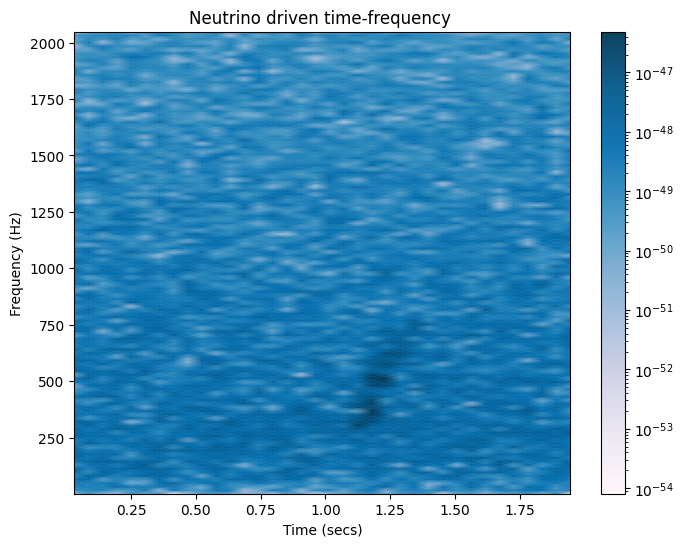

In [ ]:
prepareImage_ml(neutrino,fs,"Neutrino driven time-frequency ")

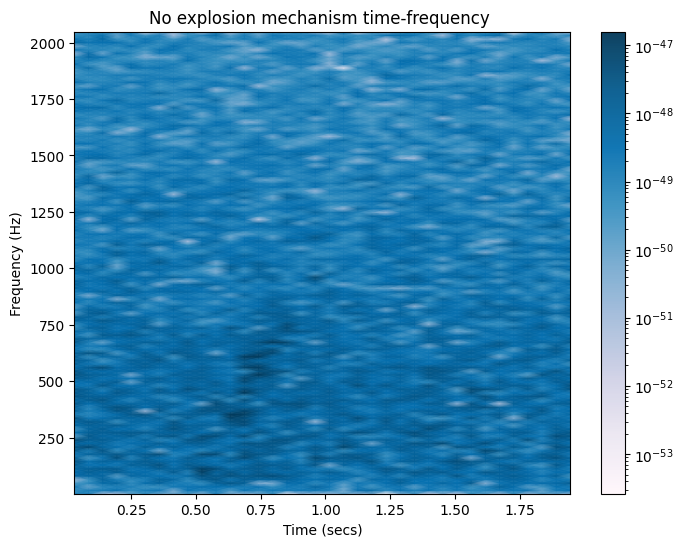

In [ ]:
prepareImage_ml(noexp,fs,"No explosion mechanism time-frequency ")

### Load data and create data frame for analysis

Now we want to use the 2D-CNN pipeline, so we need to transform the time series in images, as the plot we showed above

In [ ]:
os.listdir('../../data/timeseries')

['neutrino', 'chirp', 'magrot', 'noexp']

## Create and save an image dataset

**We have prepared the dat sets you can download here**

In [ ]:
#Import necessary libraries
import os

# Define the URL of the original file to download
url_orig = "https://owncloud.ego-gw.it/index.php/s/IFls97hbY0lyVnh/download"

# Define the target directory path where the file will be downloaded
target_path = '../../data/'

# Check if the target directory exists, and create it if it doesn't
if not os.path.exists(target_path):
    os.mkdir(target_path)

# Define the path where the downloaded file will be saved
target_file = '../../data/images.tgz'

# Call the 'download' function (which is assumed to be defined elsewhere)
# to download the file from the specified URL and save it to the target path

if not os.path.isfile(target_file):
    download(url_orig, target_file)


**You can extract the dataset**

In [ ]:
# Import the necessary library for working with tar files
import tarfile

# Open the tar file located at 'target_file' for reading
tardata = tarfile.open(target_file)

# Extract all the contents of the tar file to the specified 'target_path'
tardata.extractall(target_path)

# Close the tar file to release system resources
tardata.close()

Let's open the images and have a look at them

In [ ]:
display.Image("../../data/images/chirp/chirp_snr40_7.png")

In [ ]:
display.Image("../../data/images/magrot/magrot_snr40_7.png")

In [ ]:
display.Image("../../data/images/neutrino/neutrino_snr40_7.png")

In [ ]:
display.Image("../../data/images/noexp/noexp_snr40_7.png")

In [ ]:
from PIL import Image

im = Image.open("../../data/images/noexp/noexp_snr40_7.png")

print(im.size)
print(type(im.size))

### We need to prepare our datsets for CCN-2D pipeline.
- Load the images and resize
- Add the labels
- Reshape as input for the CNN-2D

In [ ]:
# Import necessary libraries
from PIL import Image
import numpy as np

def LoadandResizeImage_ml(filename):
    """
    Open an image file, resize it to specific dimensions, and return it as a NumPy array.

    Parameters:
        filename (str): The path to the image file to be opened and resized.

    Returns:
        numpy.ndarray: The resized image data as a NumPy array.
    """
    # Open the image file specified by 'filename'
    im = Image.open(filename)

    # Resize the opened image to the dimensions (80, 60)
    imr = im.resize((80, 60))

    # Convert the resized image to a NumPy array
    numpydata = np.asarray(imr)

    # Return the resized image as a NumPy array
    return numpydata

In [ ]:
# Define the target path where image data is located
target_path = "../../data/images/"

# Define the subdirectory path for the 'chirp' category
embed_path = target_path + 'chirp/'

# Initialize lists to store image data and corresponding labels
arr_img = []  # List to store image data
Y_label = []  # List to store labels

# Iterate over files in the 'chirp' category
for file in os.listdir(embed_path):
    # Load and resize the image file located at 'embed_path + file'
    temp = LoadandResizeImage_ml(embed_path + file)

    # Append the resized image to 'arr_img' list
    arr_img.append(temp)

    # Append the label '0' (indicating 'chirp') to 'Y_label' list
    Y_label.append(0)
# Repeat the process for other categories ('magrot', 'neutrino', 'noexp') with different labels
target_path="../../data/images/"
embed_path = target_path+'magrot/'
for file in os.listdir(embed_path):
    temp = LoadandResizeImage_ml(embed_path+file)
    arr_img.append(temp)
    Y_label.append(1)
target_path="../../data/images/"
embed_path = target_path+'neutrino/'
for file in os.listdir(embed_path):
    temp = LoadandResizeImage_ml(embed_path+file)
    arr_img.append(temp)
    Y_label.append(2)
target_path="../../data/images/"
embed_path = target_path+'noexp/'
for file in os.listdir(embed_path):
    temp = LoadandResizeImage_ml(embed_path+file)
    arr_img.append(temp)
    Y_label.append(3)

# Print the total number of images and labels
print (len(arr_img),len(Y_label))


In [ ]:
# build our numpy array for analysis
X=np.array(arr_img)
Y=np.array(Y_label)

#### Let's prepare test, training and validation data sets

In [ ]:
# Import necessary libraries from scikit-learn
import sklearn
from sklearn.model_selection import train_test_split

# Split a dataset into training and testing subsets
# Parameters:
# - X (array-like or pd.DataFrame): The input features or data.
# - Y (array-like or pd.Series): The target labels or values.
# - random_state (int or None, optional): Seed for the random number generator (randomizes the data split).
#   If not provided, the data split will be random each time.
# - test_size (float or int, optional): The proportion or absolute number of the test set. Defaults to 0.25.

# Returns:
# - x_train (array-like): The training data.
# - x_test (array-like): The testing data.
# - y_train (array-like): The training labels.
# - y_test (array-like): The testing labels.
x_train, x_test, y_train, y_test = train_test_split(X, Y, random_state=52, test_size=0.2)


## We will try to classify the signals using 2D-CNN model

In [ ]:
import tensorflow as tf
from tensorflow.python.client import device_lib
from tensorflow import keras
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
#from tensorflow.keras.layers.advanced_activations import *
from tensorflow.keras.callbacks import Callback,EarlyStopping,ModelCheckpoint


In [ ]:

gpus=tf.config.list_physical_devices('GPU')
if gpus:
    try:
        # Configure the first available GPU memory to 11GB
        tf.config.experimental.set_virtual_device_configuration(
            gpus[0],
            [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=8192)])            #   Limiting to 8GB
    except RuntimeError as e:
        print(e)


In [ ]:

# Define the number of output classes for the model
num_classes = 4

# Create a Sequential model, which is a linear stack of layers
model = tf.keras.Sequential([
    # Rescale input values to the range [0, 1]
    tf.keras.layers.Rescaling(1./255),

    # Apply a 2D convolutional layer with 32 filters and a 3x3 kernel, using ReLU activation
    tf.keras.layers.Conv2D(32, 3, activation='relu'),

    # Apply max-pooling to reduce the spatial dimensions
    tf.keras.layers.MaxPooling2D(),

    # Apply another 2D convolutional layer with 32 filters and a 3x3 kernel, using ReLU activation
    tf.keras.layers.Conv2D(32, 3, activation='relu'),

    # Apply max-pooling to further reduce spatial dimensions
    tf.keras.layers.MaxPooling2D(),

    # Apply a third 2D convolutional layer with 32 filters and a 3x3 kernel, using ReLU activation
    tf.keras.layers.Conv2D(32, 3, activation='relu'),

    # Apply max-pooling to further reduce spatial dimensions
    tf.keras.layers.MaxPooling2D(),

    # Flatten the output to a 1D tensor
    tf.keras.layers.Flatten(),

    # Apply a fully connected (dense) layer with 128 units and ReLU activation
    tf.keras.layers.Dense(128, activation='relu'),

    # Apply a fully connected (dense) layer with 'num_classes' output units
    tf.keras.layers.Dense(num_classes)
])

In [ ]:
# Import necessary libraries
from tensorflow import keras

# Define the number of training epochs and batch size
epochs = 20
batch_size = 32

# Create a list of callbacks to be used during training
callbacks = [
    # ModelCheckpoint callback: Saves the best model based on validation loss
    keras.callbacks.ModelCheckpoint("best_model.keras", save_best_only=True, monitor="val_loss"),

    # ReduceLROnPlateau callback: Adjusts learning rate when validation loss plateaus
    keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss", factor=0.5, patience=20, min_lr=0.0001
    ),

    # EarlyStopping callback: Stops training early if validation loss doesn't improve
    keras.callbacks.EarlyStopping(monitor="val_loss", patience=50, verbose=0),
]

# Compile the model with the specified optimizer, loss function, and evaluation metric
model.compile(
    optimizer='adam',
    loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)

# Train the model using the provided training data
history = model.fit(
    x_train,                    # Training data
    y_train,                    # Training labels
    batch_size=batch_size,      # Batch size for training
    epochs=epochs,              # Number of training epochs
    callbacks=callbacks,        # List of callback functions
    validation_split=0.2,       # Fraction of training data to use for validation
    verbose=1,                  # Verbosity level (0: silent, 1: progress bar, 2: one line per epoch)
)

### Plot the training and validation accuracy

In [ ]:
# Define the metric to be plotted (e.g., "accuracy")
metric = "accuracy"

# Create a new figure for plotting
plt.figure()

# Plot the training and validation history for the selected metric
plt.plot(history.history[metric], label="Train " + metric,color=custom_cmap(0.2))
plt.plot(history.history["val_" + metric], label="Validation " + metric, color=custom_cmap(0.8))

# Set the title of the plot
plt.title("Model " + metric)

# Set the y-axis label
plt.ylabel(metric, fontsize="large")

# Set the x-axis label
plt.xlabel("Epoch", fontsize="large")

# Add a legend to the plot, indicating the training and validation lines
plt.legend(["Train", "Validation"], loc="best")

# Display the plot
plt.show()

# Close the figure to release system resources
plt.close()







### Predict the results on test data sets

In [ ]:
# Predict class labels for the test data using the trained model
y_predicted = model.predict(x_test)

# Find the index of the maximum predicted probability for each sample
y_pred = np.argmax(y_predicted, axis=1)

# Print the predicted class labels
print(y_pred)

# Define the class labels corresponding to the predicted indices
labels = ["chirp", "magrot", "neutrino", "noexp"]

### Build the confusion Matrix to show the results

The confusion matrix is a fundamental tool in evaluating the performance of a multi-class machine learning model. It provides a summary of the predictions made by the model and their correspondence to the actual classes in the dataset. In a multi-class scenario, the confusion matrix is a square matrix where each row represents the instances in a predicted class and each column represents the instances in an actual class. Here's an example of a confusion matrix for a multi-class model:

|    Predicted Class   |   Class A   |   Class B   |   Class C   |
|----------------------|-------------|-------------|-------------|
|      **Class A**     |     TP      |     FN      |     FN      |
|----------------------|-------------|-------------|-------------|
|      **Class B**     |     FP      |     TP      |     FN      |
|----------------------|-------------|-------------|-------------|
|      **Class C**     |     FN      |     FP      |     TP      |
|----------------------|-------------|-------------|-------------|


In the confusion matrix, the terms have the following meanings:
- **True Positives (TP)**: The number of instances correctly predicted as belonging to a particular class.
- **False Positives (FP)**: The number of instances incorrectly predicted as belonging to a particular class when they actually belong to a different class.
- **False Negatives (FN)**: The number of instances incorrectly predicted as not belonging to a particular class when they actually belong to that class.
To interpret the confusion matrix, you can analyze the distribution of predictions across the classes. Key metrics derived from the confusion matrix include:

* Accuracy: It measures the overall correctness of the model's predictions and is calculated as (TP + TN) / (TP + TN + FP + FN).
* Precision: It quantifies the model's ability to correctly identify positive instances for a given class and is calculated as TP / (TP + FP).
* Recall (also known as Sensitivity or True Positive Rate): It represents the model's ability to correctly identify positive instances out of the total actual positive instances and is calculated as TP / (TP + FN).
* F1-score: It combines precision and recall into a single metric and is calculated as the harmonic mean of precision and recall, given by 2 * (Precision * Recall) / (Precision + Recall).
By analyzing the values in the confusion matrix and these metrics, you can gain insights into the strengths and weaknesses of your multi-class machine learning model and make informed decisions about improving its performance.

In [ ]:
# Import necessary libraries for generating and displaying a confusion matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Compute the confusion matrix based on the true labels (y_test) and predicted labels (y_pred)
cm = confusion_matrix(y_test, y_pred)

# Create a ConfusionMatrixDisplay object to visualize the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)

# Plot the confusion matrix
disp.plot(cmap=custom_cmap)
plt.title('Confusion Matrix with Custom Colormap')
plt.show()

In [ ]:

cm=confusion_matrix(y_test, y_pred,normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=labels)
disp.plot(cmap=custom_cmap)
plt.title('Confusion Matrix with Custom Colormap')
plt.show()

## Alternative way to do the same classification, using keras functions

* https://www.tensorflow.org/tutorials/load_data/images?hl=it
* https://www.tensorflow.org/tutorials/images/classification?hl=it

In [ ]:
# Import the necessary TensorFlow and Keras libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

# Import the 'pathlib' library for handling file paths
import pathlib

# Define the URL of the dataset to be downloaded (adjust to your dataset)
dataset_url = "https://owncloud.ego-gw.it/index.php/s/IFls97hbY0lyVnh/download"

# Use the 'tf.keras.utils.get_file' function to download and extract the dataset
# - 'origin': The URL of the dataset to download.
# - 'fname': The local file name to save the dataset as.
# - 'untar': Set to True to automatically extract the dataset if it's compressed.
data_dir = tf.keras.utils.get_file(
    origin=dataset_url,
    fname='images',  # Specify the local filename for the downloaded dataset.
    untar=True  # Extract the dataset if it's in a compressed format (e.g., tar.gz).
)

# Convert the downloaded data directory path into a 'pathlib.Path' object for easy manipulation
data_dir = pathlib.Path(data_dir)

In [ ]:
image_count = len(list(data_dir.glob('*/*.png')))
print(image_count)

In [ ]:
import PIL
chirps = list(data_dir.glob('chirp/*'))
PIL.Image.open(str(chirps[0]))

In [ ]:
batch_size = 32
img_height = 60
img_width = 80

In [ ]:
ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size,
  labels='inferred',
  label_mode='int',
  class_names=['chirp','magrot','neutrino','noexp']
)
print(tf.data.experimental.cardinality(
    ds))

In [ ]:
ds_size=int(tf.data.experimental.cardinality(ds))

In [ ]:
def get_dataset_partitions_tf(ds, ds_size, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1

    if shuffle:
        # Specify seed to always have the same split distribution between runs
        ds = ds.shuffle(shuffle_size, seed=12)

    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)

    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)

    return train_ds, val_ds, test_ds

In [ ]:

train_ds, val_ds, test_ds=get_dataset_partitions_tf(ds, ds_size, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000)

In [ ]:
class_names = ds.class_names
print(class_names)




In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(8):
    ax = plt.subplot(4,4 , i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [ ]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

In [ ]:
for image_batch, labels_batch in test_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

In [ ]:
for image_batch, labels_batch in val_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

In [ ]:
normalization_layer = tf.keras.layers.Rescaling(1./255)

In [ ]:
import numpy as np
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [ ]:
num_classes = 4

model = tf.keras.Sequential([
  tf.keras.layers.Rescaling(1./255),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(num_classes)
])



In [ ]:
model.compile(
  optimizer='adam',
  loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

In [ ]:
epochs=20
history=model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

In [ ]:
model.summary()

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
data_augmentation = tf.keras.Sequential(
  [

    tf.keras.layers.RandomRotation(0.1),
    tf.keras.layers.RandomZoom(0.1),
  ]
)

In [ ]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

In [ ]:

model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

In [ ]:
model.summary()

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
sns.set_style('darkgrid')
classes=ds.class_names # ordered list of class names
ytrue=[]
for images, label in test_ds:
    for e in label:
        ytrue.append(e) # list of class names associated with each image file in test dataset

ypred=[]

preds=model.predict(test_ds, verbose=1) # predict on the test data

y_pred = np.argmax(model.predict(test_ds), axis=1)
y_true = ytrue




In [ ]:
confusion_mtx = tf.math.confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx,
            xticklabels=classes,
            yticklabels=classes,
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

In [ ]:
cm=confusion_matrix(y_true, y_pred,normalize='true')
plt.figure(figsize=(10, 8))
sns.heatmap(cm,
            xticklabels=classes,
            yticklabels=classes,
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

## Let's check the predictions

In [ ]:
img_path='../../data/images/neutrino/neutrino_snr25_234.png'
img = tf.keras.utils.load_img(
    img_path, target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

In [ ]:
img_path='../../data/images/chirp/chirp_snr25_6.png'
img = tf.keras.utils.load_img(
    img_path, target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

In [ ]:
tf.keras.backend.clear_session()